In [1]:
import pandas as pd # manipulação de dados em formato de dataframe
import numpy as np # operações matemáticas
import seaborn as sns # visualização gráfica
import matplotlib.pyplot as plt # visualização gráfica
from scipy.interpolate import UnivariateSpline # curva sigmoide suavizada
import statsmodels.api as sm # estimação de modelos
import statsmodels.formula.api as smf # estimação do modelo logístico binário
from statstests.process import stepwise # procedimento Stepwise
from scipy import stats # estatística chi2
import plotly.graph_objects as go # gráficos 3D
from statsmodels.iolib.summary2 import summary_col # comparação entre modelos
from statsmodels.discrete.discrete_model import MNLogit # estimação do modelo
                                                        #logístico multinomial
import warnings
warnings.filterwarnings('ignore')

*Variável dependente é policotômica!!*

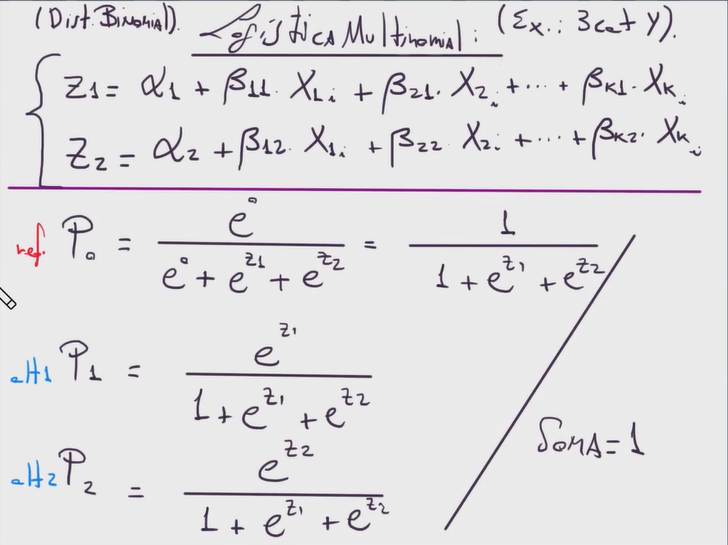

Diferença entre a estimação por máxima verossimilhança (Regressão Logística) e máximos quadrados ordinários (Regressão Linear):

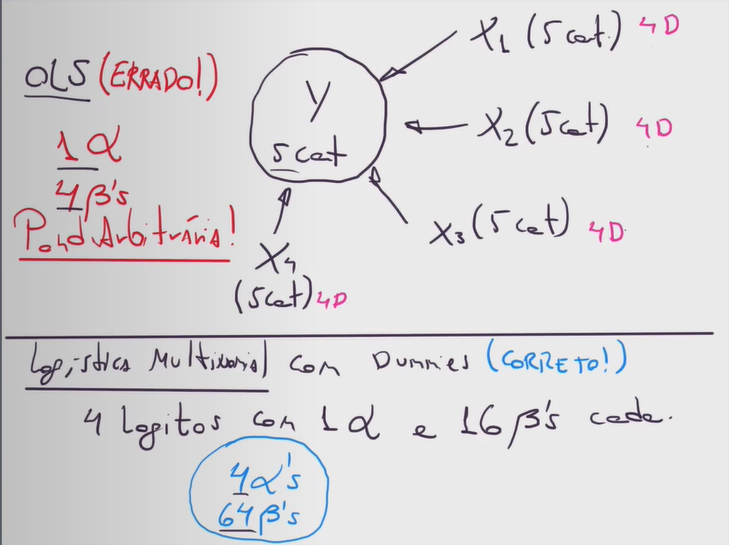

In [23]:
df_atrasado_multinomial = pd.read_csv('../data/atrasado_multinomial.csv',delimiter=',')
df_atrasado_multinomial

,estudante,atrasado,dist,sem
0,Gabriela,chegou atrasado segunda aula,20.500000,15
1,Patricia,chegou atrasado segunda aula,21.299999,18
2,Gustavo,chegou atrasado segunda aula,21.400000,16
3,Leticia,chegou atrasado segunda aula,31.500000,15
4,Luiz Ovidio,chegou atrasado segunda aula,17.500000,16
...,...,...,...,...
95,Sheila,nao chegou atrasado,24.000000,10
96,Pedro,chegou atrasado primeira aula,15.000000,15
97,Horacio,chegou atrasado primeira aula,14.400000,15
98,Leandro,chegou atrasado segunda aula,22.200001,18


In [27]:
# Características das variáveis do dataset
df_atrasado_multinomial.info()

# Estatísticas univariadas
df_atrasado_multinomial.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   estudante  100 non-null    object 
 1   atrasado   100 non-null    object 
 2   dist       100 non-null    float64
 3   sem        100 non-null    int64  
 4   atrasado2  100 non-null    int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ KB


,dist,sem,atrasado2
count,100.000000,100.000000,100.000000
mean,17.673000,13.810000,0.860000
std,5.130299,3.329376,0.910322
min,1.000000,10.000000,0.000000
25%,14.950000,10.000000,0.000000
50%,18.750000,15.000000,1.000000
75%,21.000000,18.000000,2.000000
max,31.500000,19.000000,2.000000


In [28]:
# Note que a variável Y 'atrasado' está definida como objeto

# Tabela de frequências absolutas da variável 'atrasado' com labels
df_atrasado_multinomial['atrasado'].value_counts().sort_index()

# Criando uma variável 'atrasado2' a partir da variável 'atrasado',
# com labels iguais a 0, 1 e 2 e com tipo 'int' (poderia também ser do tipo
# 'float'), a fim de que seja possível estimar o modelo por meio
# da função 'MNLogit' do pacote 'statsmodels.discrete.discrete_model'

df_atrasado_multinomial.loc[df_atrasado_multinomial['atrasado']==
                            'nao chegou atrasado',
                            'atrasado2'] = 0 #categoria de referência

df_atrasado_multinomial.loc[df_atrasado_multinomial['atrasado']==
                            'chegou atrasado primeira aula',
                            'atrasado2'] = 1

df_atrasado_multinomial.loc[df_atrasado_multinomial['atrasado']==
                            'chegou atrasado segunda aula',
                            'atrasado2'] = 2

# Definição do tipo 'int' para a variável dependente 'atrasado2'
df_atrasado_multinomial['atrasado2'] =\
    df_atrasado_multinomial['atrasado2'].astype('int64')

df_atrasado_multinomial.info()

df_atrasado_multinomial

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   estudante  100 non-null    object 
 1   atrasado   100 non-null    object 
 2   dist       100 non-null    float64
 3   sem        100 non-null    int64  
 4   atrasado2  100 non-null    int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ KB


,estudante,atrasado,dist,sem,atrasado2
0,Gabriela,chegou atrasado segunda aula,20.500000,15,2
1,Patricia,chegou atrasado segunda aula,21.299999,18,2
2,Gustavo,chegou atrasado segunda aula,21.400000,16,2
3,Leticia,chegou atrasado segunda aula,31.500000,15,2
4,Luiz Ovidio,chegou atrasado segunda aula,17.500000,16,2
...,...,...,...,...,...
95,Sheila,nao chegou atrasado,24.000000,10,0
96,Pedro,chegou atrasado primeira aula,15.000000,15,1
97,Horacio,chegou atrasado primeira aula,14.400000,15,1
98,Leandro,chegou atrasado segunda aula,22.200001,18,2


In [29]:
# Estimação do modelo logístico multinomial

x = df_atrasado_multinomial.drop(columns=['estudante','atrasado','atrasado2'])
y = df_atrasado_multinomial['atrasado2']

# Esse pacote precisa que a constante seja definida pelo usuário
X = sm.add_constant(x)

# Estimação do modelo - função 'MNLogit' ('statsmodels.discrete.discrete_model')
modelo_atrasado = MNLogit(endog=y, exog=X).fit()

# Parâmetros do modelo 'modelo_atrasado'
print(modelo_atrasado.summary())

Optimization terminated successfully.
         Current function value: 0.245118
         Iterations 10
                          MNLogit Regression Results                          
Dep. Variable:              atrasado2   No. Observations:                  100
Model:                        MNLogit   Df Residuals:                       94
Method:                           MLE   Df Model:                            4
Date:                Sat, 31 Aug 2024   Pseudo R-squ.:                  0.7574
Time:                        09:27:06   Log-Likelihood:                -24.512
converged:                       True   LL-Null:                       -101.02
Covariance Type:            nonrobust   LLR p-value:                 4.598e-32
atrasado2=1       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         -33.1352     12.183     -2.720      0.007     -57.014      -9.256
dist            0.5588   

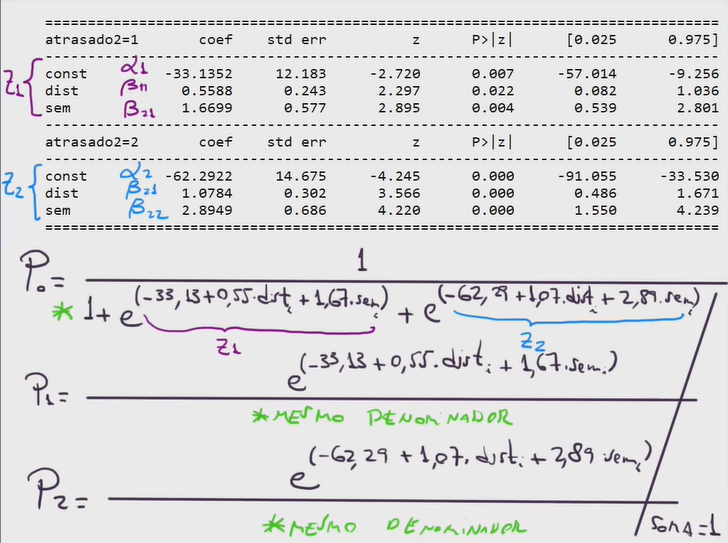

In [7]:
# Vamos definir uma função 'Qui2' para se extrair a estatística geral
# do modelo

def Qui2(modelo_multinomial):
    maximo = modelo_multinomial.llf
    minimo = modelo_multinomial.llnull
    qui2 = -2*(minimo - maximo)
    pvalue = stats.distributions.chi2.sf(qui2,4) # 4 graus de liberdade
    df = pd.DataFrame({'Qui quadrado':[qui2],
                       'pvalue':[pvalue]})
    return df

In [8]:
# Estatística geral do 'modelo_atrasado'

Qui2(modelo_atrasado)

,Qui quadrado,pvalue
0,153.014842,3.802150e-35


In [9]:
# Fazendo predições para o 'modelo_atrasado'

# Exemplo: qual a probabilidade média de atraso para cada categoria da
# variável dependente, se o indivíduo tiver que percorrer 22km e passar
# por 12 semáforos?

# No nosso exemplo, temos os seguintes labels para a variável 'atrasado2':
# 0: não chegou atrasado
# 1: chegou atrasado primeira aula
# 2: chegou atrasado segunda aula

resultado = modelo_atrasado.predict(pd.DataFrame({'const':[1],
                                                   'dist':[22],
                                                   'sem':[12]})).round(4)

resultado

# Uma maneira de identificar a classe do resultado de acordo com o 'predict'
resultado.idxmax(axis=1)

0    0
dtype: int64

In [10]:
# Adicionando as probabilidades de ocorrência de cada uma das
# categorias de Y definidas pela modelagem ao dataframe original, bem como a
# respectiva classificação

# Probabilidades de ocorrência das três categoriais
# Definição do array 'phats':
phats = modelo_atrasado.predict()
phats

# Transformação do array 'phats' para o dataframe 'phats':
phats = pd.DataFrame(phats)
phats

# Concatenando o dataframe original com o dataframe 'phats':
df_atrasado_multinomial = pd.concat([df_atrasado_multinomial, phats], axis=1)
df_atrasado_multinomial

# Analisando o resultado de acordo com a categoria de resposta:
predicao = phats.idxmax(axis=1)
predicao

# Adicionando a categoria de resposta 'predicao' ao dataframe original,
#por meio da criação da variável 'predicao'
df_atrasado_multinomial['predicao'] = predicao
df_atrasado_multinomial

# Criando a variável 'predicao_label' a partir da variável 'predicao',
#respeitando os seguintes rótulos:
# 0: não chegou atrasado
# 1: chegou atrasado primeira aula
# 2: chegou atrasado segunda aula

df_atrasado_multinomial.loc[df_atrasado_multinomial['predicao']==0,
                            'predicao_label'] ='não chegou atrasado'
df_atrasado_multinomial.loc[df_atrasado_multinomial['predicao']==1,
                            'predicao_label'] ='chegou atrasado primeira aula'
df_atrasado_multinomial.loc[df_atrasado_multinomial['predicao']==2,
                            'predicao_label'] ='chegou atrasado segunda aula'

df_atrasado_multinomial

,estudante,atrasado,dist,sem,atrasado2,0,1,2,predicao,predicao_label
0,Gabriela,chegou atrasado segunda aula,20.500000,15,2,1.801024e-02,0.523388,4.586018e-01,1,chegou atrasado primeira aula
1,Patricia,chegou atrasado segunda aula,21.299999,18,2,2.751301e-06,0.018737,9.812605e-01,2,chegou atrasado segunda aula
2,Gustavo,chegou atrasado segunda aula,21.400000,16,2,6.796190e-04,0.173472,8.258489e-01,2,chegou atrasado segunda aula
3,Leticia,chegou atrasado segunda aula,31.500000,15,2,2.759476e-07,0.003748,9.962518e-01,2,chegou atrasado segunda aula
4,Luiz Ovidio,chegou atrasado segunda aula,17.500000,16,2,2.083782e-02,0.601588,3.775739e-01,1,chegou atrasado primeira aula
...,...,...,...,...,...,...,...,...,...,...
95,Sheila,nao chegou atrasado,24.000000,10,0,9.531361e-01,0.046317,5.471598e-04,0,não chegou atrasado
96,Pedro,chegou atrasado primeira aula,15.000000,15,1,4.146183e-01,0.557343,2.803830e-02,1,chegou atrasado primeira aula
97,Horacio,chegou atrasado primeira aula,14.400000,15,1,5.008256e-01,0.481441,1.773339e-02,0,não chegou atrasado
98,Leandro,chegou atrasado segunda aula,22.200001,18,2,1.049763e-06,0.011822,9.881774e-01,2,chegou atrasado segunda aula


In [11]:
# Criação de tabela para cálculo da eficiência global do modelo

# Criando uma tabela para comparar as ocorrências reais com as predições
table = pd.pivot_table(df_atrasado_multinomial,
                       index=['predicao_label'],
                       columns=['atrasado'],
                       aggfunc='size')
table

# Substituindo 'NaN' por zero
table = table.fillna(0)
table

atrasado,chegou atrasado primeira aula,chegou atrasado segunda aula,nao chegou atrasado
predicao_label,,,
chegou atrasado primeira aula,12.0,5.0,2.0
chegou atrasado segunda aula,3.0,30.0,0.0
não chegou atrasado,1.0,0.0,47.0


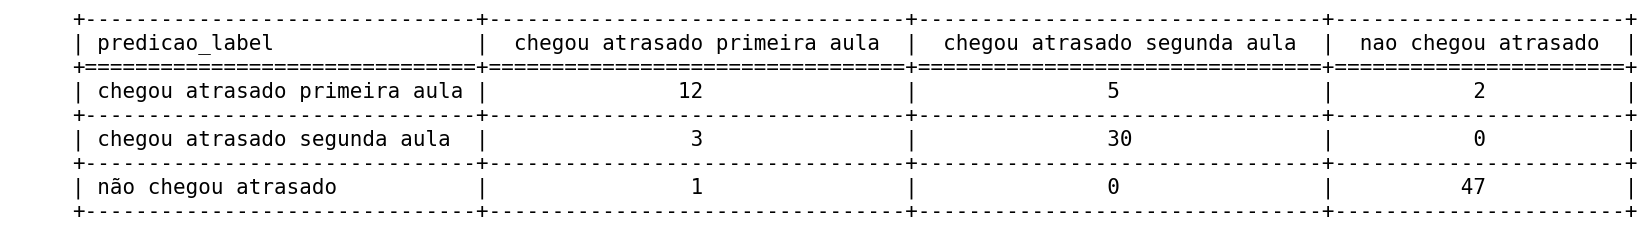

In [12]:
# Visualização, para fins didáticos, do objeto 'table' (dataframe)
# no ambiente Plots

from tabulate import tabulate
tabela = tabulate(table, headers='keys', tablefmt='grid', numalign='center')

plt.figure(figsize=(8, 3))
plt.text(0.1, 0.1, tabela, {'family': 'monospace', 'size': 15})
plt.axis('off')
plt.show()

In [13]:
# Eficiência global do modelo propriamente dita

# Transformando o dataframe 'table' para 'array', para que seja possível
# estabelecer o atributo 'diagonal'
table = table.to_numpy()
table

# Eficiência global do modelo
acuracia = table.diagonal().sum()/table.sum()
acuracia

np.float64(0.89)

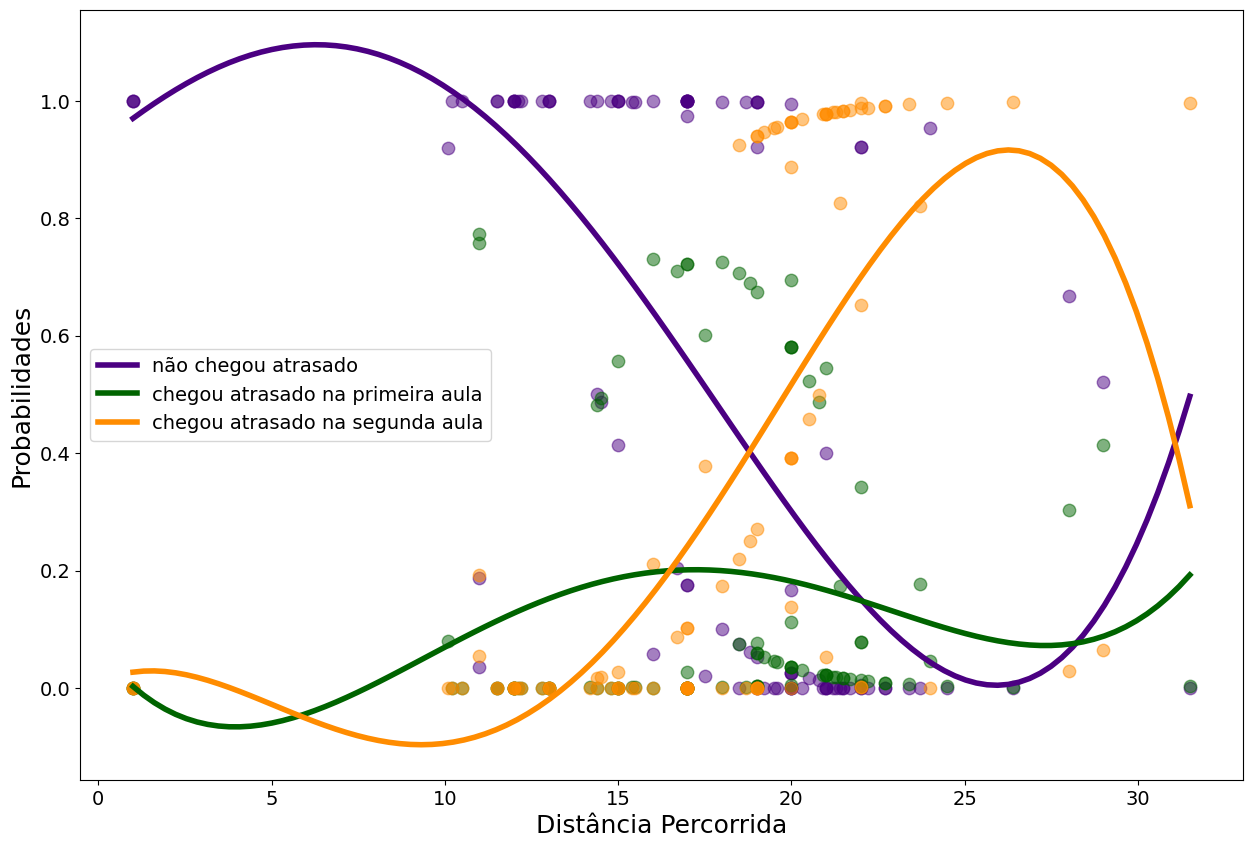

In [14]:
# Plotagens das probabilidades

# Plotagem das smooth probability lines para a variável 'dist'

# 0: não chegou atrasado
# 1: chegou atrasado primeira aula
# 2: chegou atrasado segunda aula

plt.figure(figsize=(15,10))

# Plot para "não chegou atrasado"
sns.regplot(x='dist', y=df_atrasado_multinomial[0],
            data=df_atrasado_multinomial, ci=False, order=4,
            line_kws={'color':'indigo', 'linewidth':4,
                      'label':'não chegou atrasado'},
            scatter_kws={'color':'indigo', 's':80, 'alpha':0.5})

# Plot para "chegou atrasado na primeira aula"
sns.regplot(x='dist', y=df_atrasado_multinomial[1],
            data=df_atrasado_multinomial, ci=None, order=4,
            line_kws={'color':'darkgreen', 'linewidth':4,
                      'label':'chegou atrasado na primeira aula'},
            scatter_kws={'color':'darkgreen', 's':80, 'alpha':0.5})

# Plot para "chegou atrasado na segunda aula"
sns.regplot(x='dist', y=df_atrasado_multinomial[2],
            data=df_atrasado_multinomial, ci=None, order=4,
            line_kws={'color':'darkorange', 'linewidth':4,
                      'label':'chegou atrasado na segunda aula'},
            scatter_kws={'color':'darkorange', 's':80, 'alpha':0.5})

plt.xlabel('Distância Percorrida', fontsize=18)
plt.ylabel('Probabilidades', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='center left', fontsize=14)
plt.show()

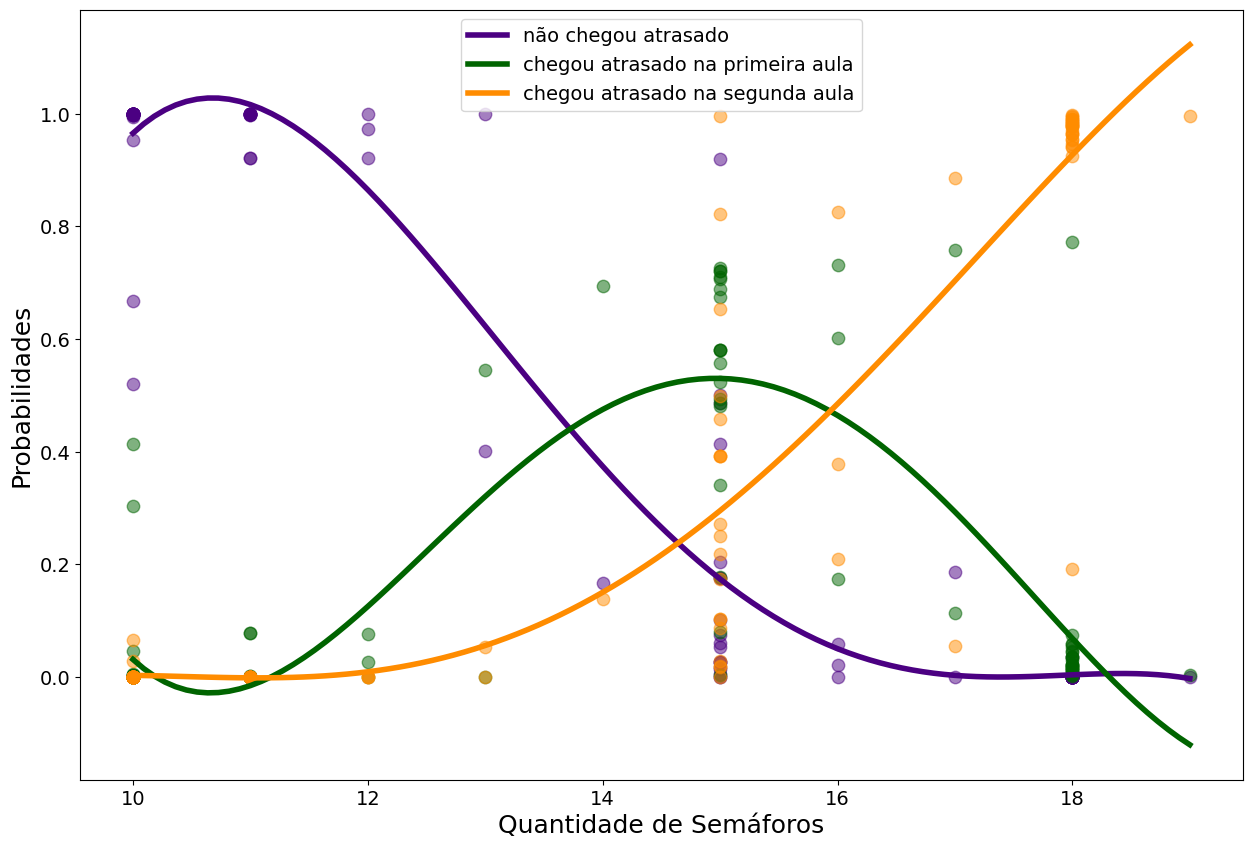

In [15]:
# Plotagens das probabilidades

# Plotagem das smooth probability lines para a variável 'sem'

# 0: não chegou atrasado
# 1: chegou atrasado primeira aula
# 2: chegou atrasado segunda aula

plt.figure(figsize=(15,10))

# Plot para "não chegou atrasado"
sns.regplot(x='sem', y=df_atrasado_multinomial[0],
            data=df_atrasado_multinomial, ci=None, order=4,
            line_kws={'color':'indigo', 'linewidth':4,
                      'label':'não chegou atrasado'},
            scatter_kws={'color':'indigo', 's':80, 'alpha':0.5})

# Plot para "chegou atrasado na primeira aula"
sns.regplot(x='sem', y=df_atrasado_multinomial[1],
            data=df_atrasado_multinomial, ci=None, order=4,
            line_kws={'color':'darkgreen', 'linewidth':4,
                      'label':'chegou atrasado na primeira aula'},
            scatter_kws={'color':'darkgreen', 's':80, 'alpha':0.5})

# Plot para "chegou atrasado na segunda aula"
sns.regplot(x='sem', y=df_atrasado_multinomial[2],
            data=df_atrasado_multinomial, ci=None, order=4,
            line_kws={'color':'darkorange', 'linewidth':4,
                      'label':'chegou atrasado na segunda aula'},
            scatter_kws={'color':'darkorange', 's':80, 'alpha':0.5})

plt.xlabel('Quantidade de Semáforos', fontsize=18)
plt.ylabel('Probabilidades', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper center', fontsize=14)
plt.show()

In [16]:
# Plotagem tridimensional para cada probabilidade de ocorrência de
# cada categoria da variável dependente

# Probabilidades de não se chegar atrasado (função 'go' do pacote 'plotly')

trace = go.Mesh3d(
    x=df_atrasado_multinomial['dist'], 
    y=df_atrasado_multinomial['sem'],
    z=df_atrasado_multinomial[0],
    opacity=1, intensity=df_atrasado_multinomial[0],
    colorscale="Viridis")

layout = go.Layout(
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0},
    width=800,
    height=800
)

data = [trace]

plot_figure = go.Figure(data=data, layout=layout)

plot_figure.update_layout(scene = dict(
                        xaxis_title='dist',
                        yaxis_title='sem',
                        zaxis_title='não chegou atrasado'))

plot_figure.show()

In [17]:
# Plotagem tridimensional para cada probabilidade de ocorrência de
# cada categoria da variável dependente

# Probabilidades de se chegar atrasado à primeira aula (função 'go' do pacote
# 'plotly')

trace = go.Mesh3d(
    x=df_atrasado_multinomial['dist'], 
    y=df_atrasado_multinomial['sem'],
    z=df_atrasado_multinomial[1],
    opacity=1, intensity=df_atrasado_multinomial[1],
    colorscale="Viridis")

layout = go.Layout(
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0},
    width=800,
    height=800
)

data = [trace]

plot_figure = go.Figure(data=data, layout=layout)

plot_figure.update_layout(scene = dict(
                        xaxis_title='dist',
                        yaxis_title='sem',
                        zaxis_title='chegou atrasado à primeira aula'))

plot_figure.show()

In [18]:
# Plotagem tridimensional para cada probabilidade de ocorrência de
# cada categoria da variável dependente

# Probabilidades de se chegar atrasado à segunda aula (função 'go' do pacote
# 'plotly')

trace = go.Mesh3d(
    x=df_atrasado_multinomial['dist'], 
    y=df_atrasado_multinomial['sem'],
    z=df_atrasado_multinomial[2],
    opacity=1, intensity=df_atrasado_multinomial[2],
    colorscale="Viridis")

layout = go.Layout(
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0},
    width=800,
    height=800
)

data = [trace]

plot_figure = go.Figure(data=data, layout=layout)

plot_figure.update_layout(scene = dict(
                        xaxis_title='dist',
                        yaxis_title='sem',
                        zaxis_title='chegou atrasado à segunda aula'))

plot_figure.show()

In [19]:
# Visualização das sigmoides tridimensionais em um único gráfico

trace = go.Mesh3d(
    x=df_atrasado_multinomial['dist'], 
    y=df_atrasado_multinomial['sem'],
    z=df_atrasado_multinomial[0],
    opacity=1,
    color='indigo')

layout = go.Layout(
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0},
    width=800,
    height=800
)

data = [trace]

plot_figure = go.Figure(data=data, layout=layout)

trace_1 = go.Mesh3d(
            x=df_atrasado_multinomial['dist'], 
            y=df_atrasado_multinomial['sem'],
            z=df_atrasado_multinomial[1],
            opacity=1,
            color='darkgreen')

plot_figure.add_trace(trace_1)

trace_2 = go.Mesh3d(
            x=df_atrasado_multinomial['dist'], 
            y=df_atrasado_multinomial['sem'],
            z=df_atrasado_multinomial[2],
            opacity=1,
            color='darkorange')


plot_figure.add_trace(trace_2)

plot_figure.update_layout(
    template='plotly_dark',
    scene = dict(
        xaxis_title='dist',
        yaxis_title='sem',
        zaxis_title='probabilidades')
    )

plot_figure.show()